# SpecSpex: A Tool for Building Professionals


## Background

Architects, developers, builders and their clients sometimes undertake "spec" projects. These are "speculative" houses that aren't customized for any particular occupant. 

In some cases, the client (or the architect / builder etc) already owns a piece of property that they want to build on. In other cases, they may be looking for promising lots for sale for the purpose of building a spec house. In either case, they want to maximize the sale price of the spec house so that they can turn the most profit. They are flexible on the actual characteristics of the house. 

## Problem Statement

> **This project identifies characteristics of a house or the lot itself that building professionals should emphasize in order to increase the sale price of new homes.**

Because some people have plots of land in mind while others don't, I need to build a tool that could be used in either scenario. 

I created one model that can advise on features of the lot itself, in the case where the builder needs to acquire a piece of land. The idea is that in this scenario, the builder might be able to add value to the project by choosing a lot with certain features. 

The "lots only" model can explain about 63% of sale prices. I ended up using this model as a baseline, similar to how a piece of land is a baseline for a home. 

I created a second model that can advise on the features of the house, in the case where the land has already been acquired and land features are non-negotiable. This model looks at recently built or remodeled homes only, because spec houses are new construction almost by definition. 


In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
# read in the datasets
train = pd.read_csv('../project_2/datasets/train.csv')
test = pd.read_csv('../project_2/datasets/test.csv')

## Cleaning and EDA

### Summary Statistics

There are 2051 homes in the dataset, ranging in price from \\$12,789 to \\$214,000. The median price is \\$162,500 and the mean is \\$181,469, suggesting a somewhat skewed distribution of prices, which is borne out in the histogram below. 

The sales occurred from 2006 - 2010. For a closer look at the age of the homes, see below. 

The houses range in size from 334 sf of livable area to 5542 sf. The lots range from 1300 sf to 159,000 sf (approx. 3.7 acres). See below for a more detailed account of lot size. 

The median number of bedrooms is 3. Many people looking at home listings are accustomed to a total count bathrooms as well, but this is not readily apparent from this dataset because bathrooms are counted separately depending whether they are full or half-bath, above or below grade. See below for treatment of this point of potential confusion. 

In [3]:
pd.set_option('display.max_columns', None)
#https://towardsdatascience.com/how-to-show-all-columns-rows-of-a-pandas-dataframe-c49d4507fcf
train.describe()

,Id,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2051.000000,2.051000e+03,2051.000000,1721.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2029.000000,2050.000000,2050.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2049.000000,2049.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,1937.000000,2050.000000,2050.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000,2051.000000
mean,1474.033642,7.135900e+08,57.008776,69.055200,10065.208191,6.112140,5.562165,1971.708922,1984.190151,99.695909,442.300488,47.959024,567.728293,1057.987805,1164.488055,329.329108,5.512921,1499.330083,0.427526,0.063446,1.577279,0.371039,2.843491,1.042906,6.435885,0.590931,1978.707796,1.776585,473.671707,93.833740,47.556802,22.571916,2.591419,16.511458,2.397855,51.574354,6.219893,2007.775719,181469.701609
std,843.980841,1.886918e+08,42.824223,23.260653,6742.488909,1.426271,1.104497,30.177889,21.036250,174.963129,461.204124,165.000901,444.954786,449.410704,396.446923,425.671046,51.068870,500.447829,0.522673,0.251705,0.549279,0.501043,0.826618,0.209790,1.560225,0.638516,25.441094,0.764537,215.934561,128.549416,66.747241,59.845110,25.229615,57.374204,37.782570,573.393985,2.744736,1.312014,79258.659352
min,1.000000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.500000,5.284581e+08,20.000000,58.000000,7500.000000,5.000000,5.000000,1953.500000,1964.500000,0.000000,0.000000,0.000000,220.000000,793.000000,879.500000,0.000000,0.000000,1129.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129825.000000
50%,1486.000000,5.354532e+08,50.000000,68.000000,9430.000000,6.000000,5.000000,1974.000000,1993.000000,0.000000,368.000000,0.000000,474.500000,994.500000,1093.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2198.000000,9.071801e+08,70.000000,80.000000,11513.500000,7.000000,6.000000,2001.000000,2004.000000,161.000000,733.750000,0.000000,811.000000,1318.750000,1405.000000,692.500000,0.000000,1728.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,313.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,5095.000000,1862.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1418.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,611657.000000


### Dropping columns
A few categorical columns have almost no variation within the dataset. These include:
- `Utilities`
- `Street`
- `Heating` (especially considering that there are two categories for natural gas heat!)
- `Pool Area` and `Pool QC`

While a few other columns have so much variation that no conclusions can be drawn:
- `Misc Feature` and `Misc Val` (most houses don't have anything, but those that do tend to have all sorts of things that are likely to be very custom to the house occupant and therefore irrelevant to this problem)
- `PID` is secondary ID number, but we already have an `Id` column that we can use 

I created a separate column, `has_pool`, which is just a binary indicator whether the house has a swimming pool or not. Since there are so few houses in the sample with pools, it's unlikely that we can learn much from the size or condition of the pool. But since it's commonly assumed that there is a relationship between having a swimming pool and a high home value, it seems worth preserving enough information about the presence or absence of a pool to investigate further. 

All the other columns were dropped. 

In [4]:
train['Utilities'].value_counts()

AllPub    2049
NoSewr       1
NoSeWa       1
Name: Utilities, dtype: int64

In [5]:
train['Street'].value_counts()

Pave    2044
Grvl       7
Name: Street, dtype: int64

In [6]:
train['Heating'].value_counts()

GasA    2018
GasW      20
Wall       6
Grav       5
OthW       2
Name: Heating, dtype: int64

In [7]:
train['Pool QC'].value_counts()

Gd    4
TA    2
Fa    2
Ex    1
Name: Pool QC, dtype: int64

In [8]:
train['has_pool'] = [1 if type(x) == float else 0 for x in train['Pool QC']]
test['has_pool'] = [1 if type(x) == float else 0 for x in test['Pool QC']]

In [9]:
train.drop(columns = ['Pool Area', 'Pool QC', 'Utilities', 'Street', 'Heating', 
                      'Misc Val', 'Misc Feature', 'PID'], inplace = True)
test.drop(columns = ['Pool Area', 'Pool QC', 'Utilities', 'Street', 'Heating', 
                      'Misc Val', 'Misc Feature', 'PID'], inplace = True)

### Nulls and Datatypes

I identified a few columns to change the data type:
- `Id` should probably be a `str`
- `Alley` and `Central Air` could both become binary `int` columns

In addition, many home characteristics in this dataset are described on a 5-point rating scale from "Poor" to "Excellent," which I decided to convert to a numeric scale. 

When a column in this dataset refers to the quality or characteristics of a particular home feature not present in a given home, that home has a null value there. For example, the `Fence` column describes the type of fence, and if a home does not have a fence at all, it is null there. For this reason, I zero-filled all nulls in the dataset.

One exception to the zero-filling technique was `Lot Frontage`, which is a property of the lot that all houses should have. Because there were a large number of good data points present on this feature, I originally imputed values for the missing ones after dummification of categorical variables. But even with imputed values in place, this feature had low impact on my model, so I eventually dropped it. 

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 74 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   MS SubClass      2051 non-null   int64  
 2   MS Zoning        2051 non-null   object 
 3   Lot Frontage     1721 non-null   float64
 4   Lot Area         2051 non-null   int64  
 5   Alley            140 non-null    object 
 6   Lot Shape        2051 non-null   object 
 7   Land Contour     2051 non-null   object 
 8   Lot Config       2051 non-null   object 
 9   Land Slope       2051 non-null   object 
 10  Neighborhood     2051 non-null   object 
 11  Condition 1      2051 non-null   object 
 12  Condition 2      2051 non-null   object 
 13  Bldg Type        2051 non-null   object 
 14  House Style      2051 non-null   object 
 15  Overall Qual     2051 non-null   int64  
 16  Overall Cond     2051 non-null   int64  
 17  Year Built    

In [11]:
# change this commonly used grading scale from str to int
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html
num_scale = {
        'Ex':int(5),
        'Gd':int(4),
        'TA':int(3),
        'Fa':int(2),
        'Po':int(1),
        'NA':int(0)
}

train.replace(to_replace = num_scale, value = None, inplace = True)
test.replace(to_replace = num_scale, value = None, inplace = True)

In [12]:
train = train.fillna(0)

In [13]:
train['Id'] = train['Id'].astype(str)
train['Alley'] = train['Alley'].map(lambda x: 1 if x != 0 else x)
train['Central Air'] = (train['Central Air'] == 'Y').astype(int)
train['Lot Frontage'] = train['Lot Frontage'].map(lambda x: np.nan if x == 0 else x)
# easier to change Lot Frontage back to null than to pull it out of the fillna above
# I intended to impute values for Lot Frontage but ended up dropping the column
test['Id'] = test['Id'].map(lambda x: str(x))
test['Alley'] = test['Alley'].map(lambda x: 1 if x != 0 else x)
test['Central Air'] = (test['Central Air'] == 'Y').astype(int)
test['Lot Frontage'] = test['Lot Frontage'].map(lambda x: np.nan if x == 0 else x)

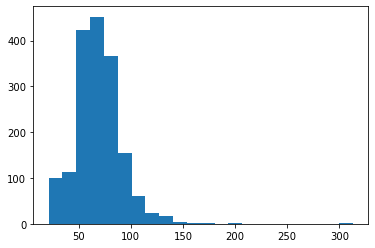

In [14]:
plt.hist(train['Lot Frontage'], bins = 22);
#distribution looks kinda normal

### Bathroom and Deck/Porch Count
For an architect or other building professional, it is standard practice to put at least one bathroom on each floor of the house. Whether a house has living space below grade may depend more on site considerations or city codes than the requirements of the occupant. For example, some soils are inappropriate for basements, or there may be a municipal code restricting building height. These are non-negotiable so they're not useful for the architect to consider. 

Moreover, most people are accustomed to counting bathrooms differently than they are counted in this dataset. I decided to combine all the bathroom counts into a single column. After some inspection of the columns, I also combined all the deck and porch area into another column. Then I dropped the individual columns.

In [15]:
train['bath_count'] = train['Bsmt Full Bath'] + train['Bsmt Half Bath'] + train['Full Bath'] + train['Half Bath']
test['bath_count'] = test['Bsmt Full Bath'] + test['Bsmt Half Bath'] + test['Full Bath'] + test['Half Bath']
train['deck_porch_sf'] = train['Wood Deck SF'] + train['Open Porch SF'] + train['Enclosed Porch'] + train['Screen Porch']
test['deck_porch_sf'] = test['Wood Deck SF'] + test['Open Porch SF'] + test['Enclosed Porch'] + test['Screen Porch']

In [16]:
train.drop(columns = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
                     'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', 'Screen Porch'], inplace = True)
test.drop(columns = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
                     'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', 'Screen Porch'], inplace = True)

### Low Sale Prices

There are some houses in this dataset with suspiciously low sale prices. Most of the low-priced homes are older, of poor quality, small, and/or in undesirable neighborhoods. My model was intended to focus on newer houses but that was not feasible, so some of these low sale prices ended up in my final model after all.

Because the standard deviation of sale price is so high (\\$79,258), *all* houses in the dataset fall within two standard deviations of the median, making a lower cut-off point somewhat arbitrary. I ended up leaving all the inexpensive houses in the data. 

As far as the most expensive homes go, those prices seemed much less suspicious. Given the data distribution, it would easier to set a justifiable upper limit. On the other hand, there are not any extreme outliers. Moreover, architect-built homes tend to be on the expensive side anyway, so for this model, I left the highest priced homes in the dataset. 

However, I do think it would be worth investigating whether there are any particular house characteristics that result in a very low home price. "Flipping" houses continues in many parts of the US so I could see an application for a model that identifies houses that sell for a low price initially but are ripe for renovations that could drastically increase their price after flipping. 

In [17]:
train['SalePrice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

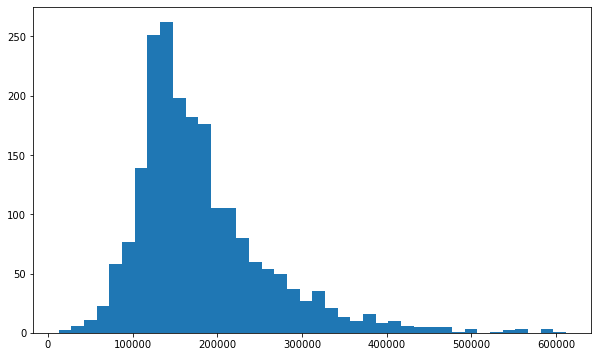

In [18]:
plt.figure(figsize = (10,6))
plt.hist(train['SalePrice'], bins = 40);

/Users/annelise/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='SalePrice'>

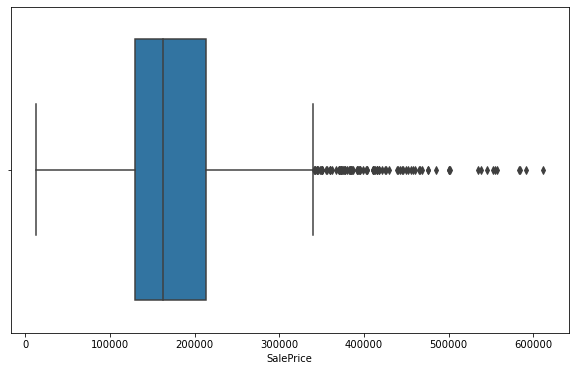

In [19]:
plt.figure(figsize = (10,6))
sns.boxplot(train['SalePrice'])

### Year Built and Remodeled
For this project, I am most interested in new homes. Comparisons to older homes are less relevant when considering new construction. 

Remodels and additions can vary widely in scope, but sometimes they are so extensive that the home ends up largely re-built from the foundation up, so it makes sense to also include newly renovated homes with new homes. 

Looking at the years for these two features, `Year Built` has a multi-modal distribution with the largest spike around 2000 and smaller spikes around 1960 and 1920. 

The multimodal peaks observed in the `Year Built` distribution are faintly echoed in the `Year Remodel/Add` distribution. Unexpectedly however, there are over 250 houses marked as remodeled in 1950 in this column, and no houses with an earlier year. Looking closely into the data reveals that houses built in 1950 and later all have either (a) their original year built or (b) a later year, as their remodel/addition year. This suggests that houses remodeled in 1949 or before are probably grouped in with the 1950 remodels. 

For all houses marked as remodeled in 1950 but built earlier, I replaced the value in the `Year Remod/Add` to match the house's `Year Built` column value. 

In [20]:
train['Year Built'].describe()

count    2051.000000
mean     1971.708922
std        30.177889
min      1872.000000
25%      1953.500000
50%      1974.000000
75%      2001.000000
max      2010.000000
Name: Year Built, dtype: float64

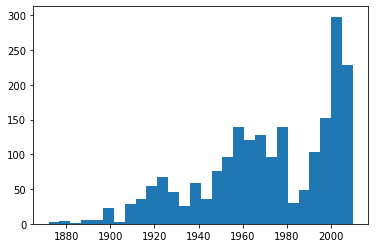

In [21]:
plt.hist(train['Year Built'], bins = 28);

In [22]:
train['Year Remod/Add'].describe()

count    2051.000000
mean     1984.190151
std        21.036250
min      1950.000000
25%      1964.500000
50%      1993.000000
75%      2004.000000
max      2010.000000
Name: Year Remod/Add, dtype: float64

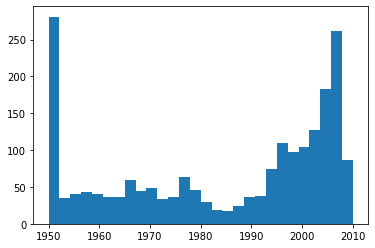

In [23]:
plt.hist(train['Year Remod/Add'], bins = 28);

In [24]:
train['Year Remod/Add'] = np.where(train['Year Remod/Add'] == 1950, train['Year Built'], train['Year Remod/Add'])
#https://stackoverflow.com/questions/39903090/efficiently-replace-values-from-a-column-to-another-column-pandas-dataframe

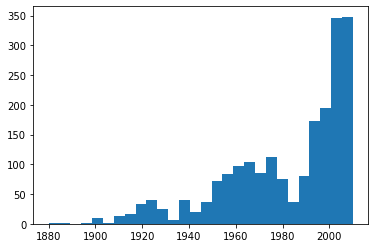

In [25]:
plt.hist(train['Year Remod/Add'], bins = 28);

### Lot Size
Lot area is quite relevant to the development of my baseline model, and I began by looking at box and whisker plots. Because land parcels vary much more widely in size than home sizes, I suspected there could be some extreme outliers, which there were. These outliers obscured the relationship between lot area and sale price. 

After looking at the two extreme outliers on the high-end of the lot area, I decided to drop houses 10 or more standard deviations away from the median. This resulted in dropping two houses, on lots of 115,149 sf (2.6 acres) and 159,000 sf (3.7 acres). 

Multi-acre lots are somewhat less likely to become spec projects. Although large lots are attractive to building professionals, typically they will want to find lots that are easy to subdivide into smaller lots or to re-zone and then subdivide. If a large lot is used for a spec project, it's much more likely that the builder or client already owns the property and wants to liquidate it. In that case, land acquisition is not part of the spec process anyway. 

In [26]:
train['Lot Area'].describe()

count      2051.000000
mean      10065.208191
std        6742.488909
min        1300.000000
25%        7500.000000
50%        9430.000000
75%       11513.500000
max      159000.000000
Name: Lot Area, dtype: float64

/Users/annelise/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


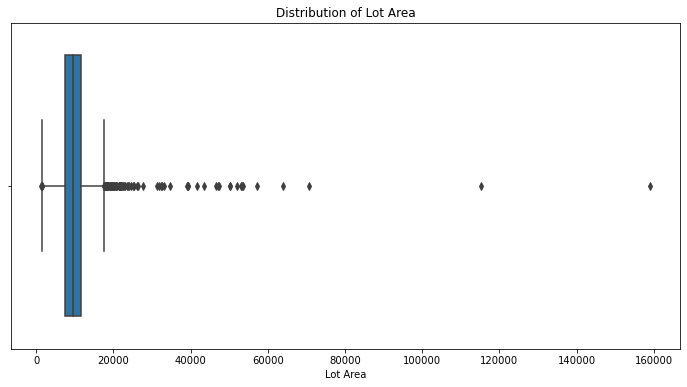

In [27]:
plt.figure(figsize = (12,6))
sns.boxplot(train['Lot Area'])
plt.title('Distribution of Lot Area');

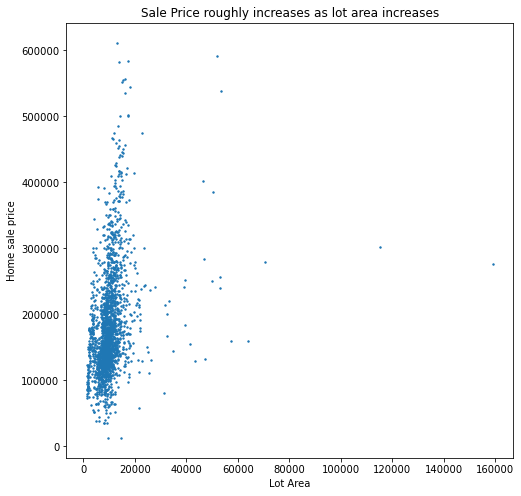

In [28]:
plt.figure(figsize = (8,8))
plt.scatter(x = train['Lot Area'], y = train['SalePrice'], s = 2)
plt.title('Sale Price roughly increases as lot area increases')
plt.xlabel('Lot Area')
plt.ylabel('Home sale price');

In [29]:
train[train['Lot Area'] >= 76850].count()

Id               2
MS SubClass      2
MS Zoning        2
Lot Frontage     0
Lot Area         2
                ..
Sale Type        2
SalePrice        2
has_pool         2
bath_count       2
deck_porch_sf    2
Length: 68, dtype: int64

In [30]:
train.sort_values('Lot Area').tail(2)

,Id,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Alley,Lot Shape,Land Contour,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,3Ssn Porch,Fence,Mo Sold,Yr Sold,Sale Type,SalePrice,has_pool,bath_count,deck_porch_sf
694,2072,20,RL,NaN,115149,0,IR2,Low,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.0,3,3,CBlock,4.0,3.0,4,GLQ,1219.0,Unf,0.0,424.0,1643.0,3,1,SBrkr,1824,0,0,1824,2,1,4,5,Typ,2,3.0,Attchd,1971.0,Unf,2.0,739.0,3.0,3.0,Y,0,0,6,2007,WD,302000,1,3.0,428
471,2116,50,RL,NaN,159000,0,IR2,Low,CulDSac,Sev,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,4,3,CBlock,4.0,3.0,4,Rec,697.0,Unf,0.0,747.0,1444.0,4,1,SBrkr,1444,700,0,2144,4,1,4,7,Typ,2,3.0,Attchd,1958.0,Fin,2.0,389.0,3.0,3.0,Y,0,0,6,2007,WD,277000,1,3.0,98


In [31]:
train.drop(train.index[[694, 471]], inplace = True)

/Users/annelise/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


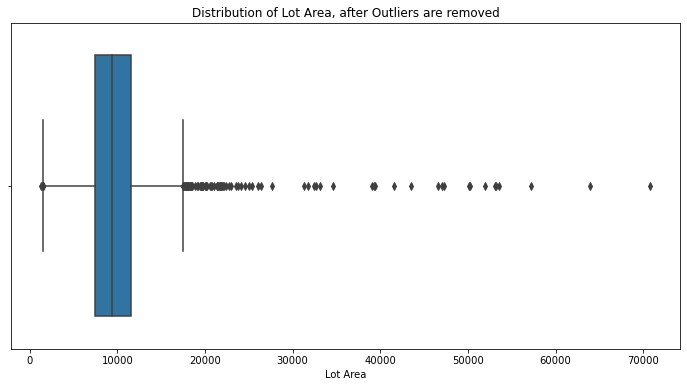

In [32]:
plt.figure(figsize = (12,6))
sns.boxplot(train['Lot Area'])
plt.title('Distribution of Lot Area, after Outliers are removed');

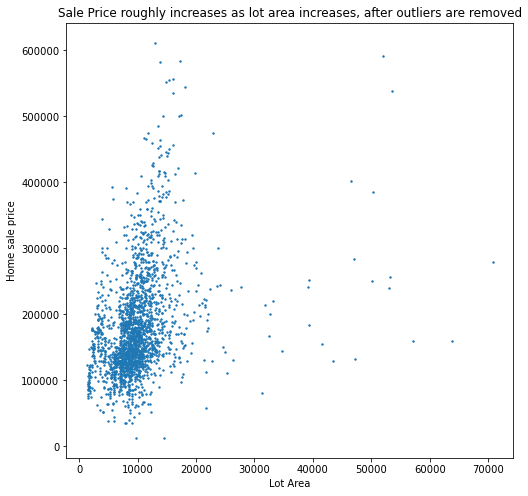

In [33]:
plt.figure(figsize = (8,8))
plt.scatter(x = train['Lot Area'], y = train['SalePrice'], s = 2)
plt.title('Sale Price roughly increases as lot area increases, after outliers are removed')
plt.xlabel('Lot Area')
plt.ylabel('Home sale price');

#### Overall Quality and Condition
The Ames dataset contains two variables that seem synonymous: `Overall Quality` and `Overall Condition`. *Overall Quality* refers to the grade of building materials used to build the home, such as vinyl windows rather than aluminum windows, or marble countertops rather than laminate. *Overall Condition* refers to how well-maintained the home is. Imagine the granny with the sparkling kitchen that hasn't been updated since 1960 and you'll understand how these variables are in fact independent of each other.

Both variables are on the same 10-point rating scale and have a similar mean across the dataset. However, the distribution is different, with `Overall Quality` following a roughly normal distribution and `Overall Condition` showing a huge spike at the median. Plotting the relationship to each other does not show any obvious pattern. Again, we can be confident that they are operating independently in this data set. 

But how important are they when it comes to sale price?

To find out, I created an interaction variable, `qual_cond`. Then I plotted Sale Price against each of the three variables. A linear relationship is most apparent when looking at Overall Quality. 

Overall Condition alone shows some linearity at the very bottom of the scale, but we already know that there are very few houses in that range. Houses in the middle of the rating scale dominate the sample and have a wide range of sale prices. Beyond the mean, there is almost no linearity at all. Overall Condition does not appear to be a meaningful driver of Sale Price.

The usefulness of the interaction variable will be diminished by the uselessness of Overall Condition. Based on these observations, I determined not to use Overall Condition alone nor the interaction variable `qual_cond`.

In [34]:
train['Overall Qual'].describe()

count    2049.000000
mean        6.111762
std         1.426830
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: Overall Qual, dtype: float64

In [35]:
train['Overall Cond'].describe()

count    2049.000000
mean        5.561737
std         1.104510
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: Overall Cond, dtype: float64

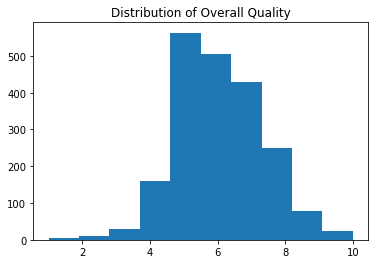

In [36]:
plt.hist(train['Overall Qual'], bins = 10)
plt.title('Distribution of Overall Quality');

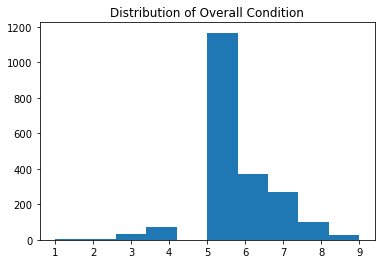

In [37]:
plt.hist(train['Overall Cond'], bins = 10)
plt.title('Distribution of Overall Condition');

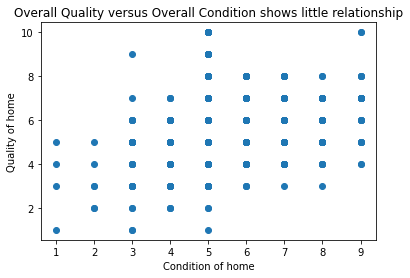

In [38]:
plt.scatter(x = train['Overall Cond'], y = train['Overall Qual'])
plt.title('Overall Quality versus Overall Condition shows little relationship')
plt.xlabel('Condition of home')
plt.ylabel('Quality of home');

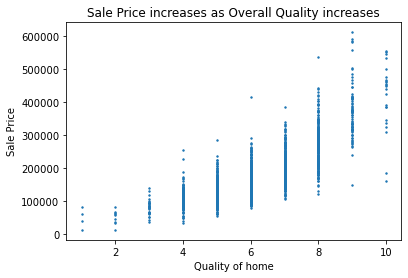

In [39]:
plt.scatter(x = train['Overall Qual'], y = train['SalePrice'], s = 2)
plt.title('Sale Price increases as Overall Quality increases')
plt.xlabel('Quality of home')
plt.ylabel('Sale Price');

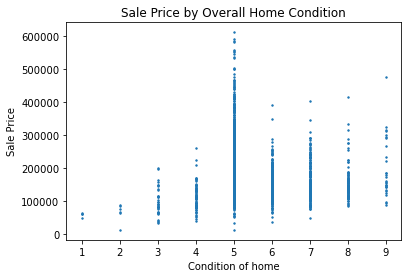

In [40]:
plt.scatter(x = train['Overall Cond'], y = train['SalePrice'], s = 2)
plt.title('Sale Price by Overall Home Condition')
plt.xlabel('Condition of home')
plt.ylabel('Sale Price');

In [41]:
train['qual_cond'] = train['Overall Qual'] * train['Overall Cond']
test['qual_cond'] = test['Overall Qual'] * test['Overall Cond']

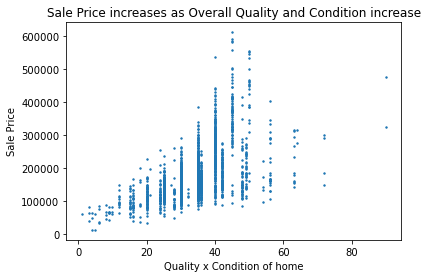

In [42]:
plt.scatter(x = train['qual_cond'], y = train['SalePrice'], s = 2)
plt.title('Sale Price increases as Overall Quality and Condition increase')
plt.xlabel('Quality x Condition of home')
plt.ylabel('Sale Price');

In [43]:
train.to_csv('clean_train.csv', index = False)
test.to_csv('clean_test.csv', index = False)

## Modeling

## Baseline OLS Model

The baseline model is focused on features of the land only. Not only is it somewhat useful to have a model that focuses on land for people who need to buy a lot for their project, but once the land is selected, those features can't be altered. All the value-added will come from the building itself. 

After several iterations of this model, I settled on the following features and created a separate data frame for lots only. I threw out `Lot Shape`, `Lot Config`, and `Lot Frontage` because they were not improving the evaluation metrics, and I was concerned that leaving them in could increase variance. 

I dummified the categorical variables and scaled the data before modeling. 

I chose `train_test_split` to validate the data because the size of the dataset allowed it and it was easier to use on scaled data. 

These are the validation scores of the baseline model:

|Model|Metric|Dataset|Value|
|---|---|---|---|
|Baseline OLS|RMSE|Train|\\$48,276.45|
|Baseline OLS|RMSE|Test|\\$43,997.25|
|Baseline OLS|R$^2$|Train|0.645|
|Baseline OLS|R$^2$|Test|0.641|

The baseline has low variance but can only explain about 64% of the predictions. The price is too high by around \\$44k - \\$48k. 

Adding features should help the next version of the model achieve lower bias without sacrificing too much variance. The baseline model was not regularized, so if variance becomes an issue in the next version of the model, regularization may be able to help address it.  

In [44]:
#create a dataframe focused on features of the land itself
train_lots = pd.DataFrame(train, columns = ['Id', 'SalePrice', 'Lot Config', 'MS Zoning', 'Lot Area', 'Land Contour', 'Neighborhood'])
test_lots = pd.DataFrame(test, columns = ['Id', 'Lot Config', 'MS Zoning', 'Lot Area', 'Land Contour', 'Neighborhood'])

In [45]:
train_lots = pd.get_dummies(data = train_lots, columns = ['MS Zoning', 'Lot Config', 'Land Contour', 'Neighborhood'], drop_first = True)
test_lots = pd.get_dummies(data = test, columns = ['MS Zoning', 'Land Contour', 'Lot Config', 'Neighborhood'], drop_first = True)

In [46]:
X_lots = train_lots.drop(columns = ['SalePrice', 'Id'])
y_lots = train_lots['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X_lots, y_lots, random_state = 42)

In [47]:
model_lots = LinearRegression()
model_lots.fit(X_train, y_train)

LinearRegression()

In [48]:
#RMSE of training data
y_pred_train = model_lots.predict(X_train)
metrics.mean_squared_error(y_train, y_pred_train, squared = False)

48276.45737542427

In [49]:
#RMSE of test data
y_pred = model_lots.predict(X_test)
metrics.mean_squared_error(y_test, y_pred, squared = False)

43997.2535722301

In [50]:
# R2 scores of train and test data
model_lots.score(X_train, y_train), model_lots.score(X_test, y_test)

(0.644913737156344, 0.6405515821103629)

In [51]:
set(zip(model_lots.coef_, X_lots))

{(-108925.08020200944, 'Neighborhood_IDOTRR'),
 (-105429.84987597389, 'Neighborhood_MeadowV'),
 (-103085.37966623565, 'Neighborhood_Landmrk'),
 (-101943.55345688065, 'Neighborhood_BrDale'),
 (-99945.10531303319, 'Neighborhood_OldTown'),
 (-90523.7298551707, 'Neighborhood_Edwards'),
 (-89337.44849315731, 'Neighborhood_BrkSide'),
 (-83604.75290075126, 'Neighborhood_Sawyer'),
 (-78144.94666685931, 'Neighborhood_Blueste'),
 (-73990.5836319128, 'Neighborhood_NAmes'),
 (-73905.43457705791, 'Neighborhood_SWISU'),
 (-59977.50832367229, 'Neighborhood_Mitchel'),
 (-46066.75971835221, 'Neighborhood_NPkVill'),
 (-38563.72725778401, 'Neighborhood_Gilbert'),
 (-36605.7207666449, 'Neighborhood_Crawfor'),
 (-33935.01216996065, 'Neighborhood_ClearCr'),
 (-32740.48049838151, 'Neighborhood_NWAmes'),
 (-28290.64173337905, 'Neighborhood_SawyerW'),
 (-21741.18367180976, 'Lot Config_FR2'),
 (-21444.602735117616, 'Lot Config_FR3'),
 (-17266.421498281765, 'Neighborhood_CollgCr'),
 (-6437.923551543355, 'Land Co

Some conclusions can be drawn even from this baseline model. This may help guide people who are trying to buy an empty lot for their spec project. 

1. **Less dense is preferred.** Low or medium density residential zones can raise final home price by about \\$40,000 over high density zoned lots. Moreover, larger lots are associated with higher house prices. 
2. **Some neighborhoods can raise home values signficantly.** Northridge Heights can raise home prices \\$51,647 over the median home price for this dataset (\\$162,500) Northridge and Stonebridge can raise the price around \\$30k over the median. On the other hand many locations depress home values, including North Ames, Old Town, Edwards, Iowa DOT and Rail Road, and Sawyer. 
3. **Hills are attractive.** A hilly lot can raise the home price about \\$6500 over level lots. I suspect that some of these sloping lots may have good views or other appealing natural features. Moreover, building on a steep slope usually requires a custom-built home, which may result in a higher quality overall. As we will see below, the overall quality of a house is a major driver of sale price.

## Improved OLS Model

Before undertaking spec projects, architects want to compare to other new construction. Therefore, I intended to only include homes that were 10 years old or less, or had been remodeled within the last 6 years, at the time the data was collected. These were homes in the highest quartile for age or remodel age. However, this resulted in too little data to train and validate the model. Given a larger dataset, I would like to try to produce a new construction focused model. 

After iterating through the model several times and looking at LASSO coefficients, I settled on the features below. I also included all the features from the baseline model.  

I added the validation scores for this model to the table from above. 

|Model|Metric|Dataset|Value|
|---|---|---|---|
|Baseline OLS|RMSE|Train|\\$48,276.45|
|Baseline OLS|RMSE|Test|\\$43,997.25|
|Baseline OLS|R$^2$|Train|0.645|
|Baseline OLS|R$^2$|Test|0.641|
|Improved OLS|RMSE|Train|\\$29698.51|
|Improved OLS|RMSE|Test|\\$26858.26|
|Improved OLS|R$^2$|Train|0.866|
|Improved OLS|R$^2$|Test|0.866|

This model has better bias and the variance is lower. Already, it is an improvement over the baseline. In the next section, I will try two regularizing models, RidgeCV and LASSO CV, to see if they improve the model further. 

In [52]:
train_house = pd.DataFrame(data = train, columns = ['Id', 'MS Zoning', 'Lot Area', 
       'Land Contour', 'Lot Config', 'Neighborhood', 'House Style',
       'Overall Qual', 'Year Built', 'Year Remod/Add','Roof Matl', 'Mas Vnr Area',
       'Foundation', 'Total Bsmt SF', 'Central Air',
       'Gr Liv Area', 'Bedroom AbvGr', 'Fireplaces', 
       'Garage Area', 'SalePrice','has_pool', 'bath_count', 'deck_porch_sf'])
test_house = pd.DataFrame(data = test, columns = ['Id', 'MS Zoning', 'Lot Area', 
       'Land Contour', 'Lot Config', 'Neighborhood', 'House Style',
       'Overall Qual', 'Year Built', 'Year Remod/Add','Roof Matl', 'Mas Vnr Area',
       'Foundation', 'Total Bsmt SF', 'Central Air',
       'Gr Liv Area', 'Bedroom AbvGr', 'Fireplaces', 
       'Garage Area', 'SalePrice','has_pool', 'bath_count', 'deck_porch_sf'])

In [53]:
train_house = pd.get_dummies(data = train_house, columns = ['MS Zoning',
       'Land Contour', 'Lot Config', 'Neighborhood', 'House Style',
       'Roof Matl', 'Foundation'], drop_first = True)
test_house = pd.get_dummies(data = test_house, columns = ['MS Zoning',
       'Land Contour', 'Lot Config', 'Neighborhood', 'House Style',
       'Roof Matl', 'Foundation'], drop_first = True)

In [54]:
X_house = train_house.drop(columns = ['SalePrice', 'Id'])
y_house = train_house['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X_house, y_house, random_state = 42)

In [55]:
model_house = LinearRegression()
model_house.fit(X_train, y_train)

LinearRegression()

In [56]:
model_house.score(X_train, y_train), model_house.score(X_test, y_test)

(0.8656207077787231, 0.866050422437537)

In [57]:
y_pred = model_house.predict(X_train)
metrics.mean_squared_error(y_train, y_pred, squared = False)

29698.508039578657

In [58]:
y_pred_test = model_house.predict(X_test)
metrics.mean_squared_error(y_test, y_pred_test, squared = False)

26858.264933206425

In [59]:
set(zip(model_house.coef_, X_house))

{(-15695.875484068798, 'Neighborhood_Landmrk'),
 (-11325.350073647716, 'Neighborhood_Blueste'),
 (-11138.956465656765, 'has_pool'),
 (-10942.022319605841, 'Lot Config_FR3'),
 (-9999.98016881315, 'Neighborhood_BrDale'),
 (-7798.6395310600365, 'Lot Config_FR2'),
 (-7530.860373202283, 'Neighborhood_NPkVill'),
 (-5408.628268159642, 'Neighborhood_NWAmes'),
 (-2109.9122580722124, 'Bedroom AbvGr'),
 (-1708.5403574729708, 'Neighborhood_Gilbert'),
 (-874.4223490017376, 'Neighborhood_SawyerW'),
 (0.9018091828006146, 'Lot Area'),
 (21.78463040512088, 'Total Bsmt SF'),
 (22.51848764037277, 'Mas Vnr Area'),
 (22.766690373940833, 'deck_porch_sf'),
 (27.57094752008379, 'Garage Area'),
 (39.92881384549128, 'Gr Liv Area'),
 (182.0864542960622, 'Year Built'),
 (195.6689563811001, 'Year Remod/Add'),
 (517.8942243030781, 'House Style_2Story'),
 (697.2712304144179, 'Lot Config_Inside'),
 (884.9393116068936, 'Foundation_CBlock'),
 (1020.8820991901459, 'Central Air'),
 (1236.4802550301615, 'Neighborhood_Edwa

## LassoCV

In [60]:
alphas = np.logspace(-3,0)
lasso_cv = LassoCV(alphas = alphas, cv = 5, max_iter = 100_000)
ss = StandardScaler()
Z_house_train = ss.fit_transform(X_train)
Z_house_test = ss.transform(X_test)
lasso_cv.fit(Z_house_train, y_train)

LassoCV(alphas=array([0.001     , 0.0011514 , 0.00132571, 0.00152642, 0.00175751,
       0.00202359, 0.00232995, 0.0026827 , 0.00308884, 0.00355648,
       0.00409492, 0.00471487, 0.00542868, 0.00625055, 0.00719686,
       0.00828643, 0.00954095, 0.01098541, 0.01264855, 0.01456348,
       0.01676833, 0.01930698, 0.02222996, 0.02559548, 0.02947052,
       0.03393222, 0.0390694 , 0.04498433, 0.05179475, 0.05963623,
       0.06866488, 0.07906043, 0.09102982, 0.10481131, 0.12067926,
       0.13894955, 0.15998587, 0.184207  , 0.21209509, 0.24420531,
       0.28117687, 0.32374575, 0.37275937, 0.42919343, 0.49417134,
       0.5689866 , 0.65512856, 0.75431201, 0.86851137, 1.        ]),
        cv=5, max_iter=100000)

In [61]:
lasso_preds_train = lasso_cv.predict(Z_house_train)
metrics.mean_squared_error(y_train, lasso_preds_train, squared = False)

29698.548381595072

In [62]:
lasso_preds_test = lasso_cv.predict(Z_house_test)
metrics.mean_squared_error(y_test, lasso_preds_test, squared = False)

26858.666653045817

In [63]:
lasso_cv.score(Z_house_train, y_train), lasso_cv.score(Z_house_test, y_test)

(0.8656203427007679, 0.8660464154322194)

In [64]:
set(zip(lasso_cv.coef_, X_house))

{(-1722.719763360723, 'Bedroom AbvGr'),
 (-1314.3292196554848, 'Lot Config_FR2'),
 (-1128.8503689857534, 'Neighborhood_NWAmes'),
 (-1043.5352612020617, 'Neighborhood_BrDale'),
 (-765.1108165859333, 'Neighborhood_NPkVill'),
 (-722.2695211517203, 'Neighborhood_Blueste'),
 (-687.8088658363404, 'has_pool'),
 (-622.4892002510246, 'Lot Config_FR3'),
 (-433.55521821310305, 'Neighborhood_Gilbert'),
 (-405.369649118147, 'Neighborhood_Landmrk'),
 (-224.78003752916732, 'Neighborhood_SawyerW'),
 (224.41361727798798, 'House Style_2Story'),
 (242.03044134380733, 'Neighborhood_Edwards'),
 (256.51683886304585, 'Central Air'),
 (302.39157962229444, 'Lot Config_Inside'),
 (330.98730051505606, 'Foundation_Wood'),
 (377.1813115382526, 'Neighborhood_SWISU'),
 (381.0727122364588, 'Neighborhood_Greens'),
 (426.650684678683, 'Foundation_CBlock'),
 (452.2555266774039, 'House Style_1.5Unf'),
 (479.3456456563243, 'House Style_2.5Fin'),
 (658.1228989518696, 'MS Zoning_I (all)'),
 (664.4738311939126, 'Neighborhood

## RidgeCV

In [65]:
ridge_cv = RidgeCV(alphas = 10)
ridge_cv.fit(Z_house_train, y_train)

RidgeCV(alphas=array(10))

In [66]:
ridge_preds_train = ridge_cv.predict(Z_house_train)
metrics.mean_squared_error(y_train, ridge_preds_train, squared = False)

29845.056171157354

In [67]:
ridge_preds_test = ridge_cv.predict(Z_house_test)
metrics.mean_squared_error(y_test, ridge_preds_test, squared = False)

27021.09986132287

In [68]:
ridge_cv.score(Z_house_train, y_train), ridge_cv.score(Z_house_test, y_test)

(0.8642912388309951, 0.8644212934352347)

## Conclusions

The linear regression model that includes features of the house outperforms the baseline model based on features of the lot alone. The RidgeCV model reduced the variance by a very small amount, but its RMSE scores are slightly higher than either the Improved OLS or the LASSO CV model. All of the models have similar RMSE and R$^2$ scores. All are improvements over the baseline model. 

Because some degree of transparency is required for this model, I recommend sticking with the improved OLS model. Building tradespeople need to be able to interpret the coefficients easily to understand what kind of decisions can move the needle on sale price. 

|Model|Metric|Dataset|Value|
|---|---|---|---|
|Baseline OLS|RMSE|Train|\\$48,276.45|
|Baseline OLS|RMSE|Test|\\$43,997.25|
|Baseline OLS|R$^2$|Train|0.645|
|Baseline OLS|R$^2$|Test|0.641|
|Improved OLS|RMSE|Train|\\$29698.51|
|Improved OLS|RMSE|Test|\\$26858.26|
|Improved OLS|R$^2$|Train|0.866|
|Improved OLS|R$^2$|Test|0.866|
|LASSO CV|RMSE|Train|\\$29698.55|
|LASSO CV|RMSE|Test|\\$26858.67|
|LASSO CV|R$^2$|Train|0.866|
|LASSO CV|R$^2$|Test|0.866|
|Ridge CV|RMSE|Train|\\$29,845.06|
|Ridge CV|RMSE|Test|\\$27,021.10|
|Ridge CV|R$^2$|Train|.864|
|Ridge CV|R$^2$|Test|.864|

### Some surprises in the model

This model is not perfect. Some surprising implications are that both `has_pool` and the bedroom count decrease home value. These are non-intuitive conclusions based on how we know the housing market works. 

To continue to improve the accuracy of my models, those are two features I would start investigating first. 

### Other Further Modeling Considerations

The model also has a number of inherently multicollinear variables from all the dummy features. I'm not sure how to deal with these, but it would be worth experimenting with them to see if the model could be improved (or at least be just as good) without all of them. 

Finally, I was very disappointed that I could not focus my dataset on new and newly remodeled homes only, because that's what's really most relevant to this problem. Having more data would make this possible, and I think it would be an improvement on the solution to the problem. 

## Recommendations for Builders

For anyone looking to take on a spec project, here are some things to consider (holding all other factors constant):
- **Location** <br>
If you don't already have a plot of land, consider purchasing land in a low- or medium-density zone. High-density zoning is associated with lower prices. Some neighborhoods are also more desirable: Northridge Heights, Northridge, and Somerset tend to have higher home prices while Edwards, North Ames, and Sawyer have lower prices. 
- **Layout is less important than living area** <br>
Large lots *are* associated with more expensive homes, but much more important is the livable area of the house (expect to increase sale price by \\$39.93/sf), the area of the garage (\\$27.59/sf), the area of the deck or porch (\\$22.76/sf), and the area of the basement (\\$21.78/sf). Lot size, by contrast, we only expect to see an increase of \\$.90/sf. <br>
Also, while number of bathrooms does increase the house price by about $6373 per bathroom, the model does not predict any particular layout will be higher priced than another. Rooms above and below grade, how many stories the house has, etc are all dwarfed by the importance of square footage. 
- **Materials Matter** <br>
In general, the overall quality of materials used is one of the very most important factors in sale price. For every unit a house moves up on the quality ranking scale, we expect to see a \\$14,495 increase in sale price. Roofing materials in particular can drive a home price up or down -- consider composite shingles, wood shingles, or wood shakes. Masonry instead of siding also raises home price. The type of foundation can also have an impact -- if you can do poured concrete, I would expect it to increase the sale price around \\$4,900. 
- **Always put in a fireplace** <br>
A fireplace is associated with a \\$6363 increase in the sale price. 

